## MODFLOW-NWT Problem 3

This example is based on problem 3 in Niswonder et al 2011, which used
the Newton-Raphson formulation to simulate water levels in a rectangular,
unconfined aquifer with a complex bottom elevation and receiving areally
distributed recharge. This problem provides a good example of the utility
of Newton-Raphson for solving problems with wetting and drying of cells.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl

import flopy
import git
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pooch
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwf-nwt-p03"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()
data_path = root / "data" / sim_name if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "meters"
time_units = "days"

# Scenario-specific parameters
parameters = {
    "ex-gwf-nwt-p03a": {
        "recharge": "high",
    },
    "ex-gwf-nwt-p03b": {
        "recharge": "low",
    },
}

# Model parameters
nper = 1  # Number of periods
nlay = 1  # Number of layers
nrow = 80  # Number of rows
ncol = 80  # Number of columns
delr = 100.0  # Cell size in the x-direction ($m$)
delc = 100.0  # Cell size in y-direction ($m$)
top = 200.0  # Top of the model ($m$)
k11 = 1.0  # Horizontal hydraulic conductivity ($m/day$)
H1 = 24.0  # Constant head water level ($m$)

# plotting ranges and contour levels
vmin, vmax = 20, 60
smin, smax = 0, 25
bmin, bmax = 0, 90
vlevels = np.arange(vmin, vmax + 5, 5)
slevels = np.arange(smin, smax + 5, 5)
blevels = np.arange(bmin + 10, bmax, 10)
vcolor = "black"
scolor = "black"
bcolor = "black"


# Time discretization
tdis_ds = ((365.0, 1, 1.0),)

# Calculate extents, and shape3d
extents = (0, delr * ncol, 0, delc * nrow)
shape3d = (nlay, nrow, ncol)
ticklabels = np.arange(0, 10000, 2000)

# Load the bottom
fname = "bottom.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:0fd4b16db652808c7e36a5a2a25da0a2",
)
botm = np.loadtxt(fpath).reshape(shape3d)

# Set the starting heads
strt = botm + 20.0

# Load the high recharge rate
fname = "recharge_high.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:8d8f8bb3cec22e7a0cbe6aba95da8f35",
)
rch_high = np.loadtxt(fpath)

# Generate the low recharge rate from the high recharge rate
rch_low = rch_high.copy() * 1e-3

# Constant head boundary conditions
chd_spd = [[0, i, ncol - 1, H1] for i in (45, 46, 47)]

# Solver parameters
nouter = 500
ninner = 500
hclose = 1e-9
rclose = 1e-6

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models(name, recharge="high"):
    sim_ws = os.path.join(workspace, name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(
        sim,
        print_option="all",
        complexity="simple",
        linear_acceleration="bicgstab",
        outer_maximum=nouter,
        outer_dvclose=hclose,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
    )
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=sim_name,
        newtonoptions="newton under_relaxation",
    )
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        icelltype=1,
        k=k11,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=strt)
    flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chd_spd)

    if recharge == "high":
        rch = rch_high
    elif recharge == "low":
        rch = rch_low
    flopy.mf6.ModflowGwfrcha(gwf, recharge=rch)

    head_filerecord = f"{sim_name}.hds"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        saverecord=[("HEAD", "ALL")],
    )
    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent)
    assert success, buff

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (6.3, 5.6)
masked_values = (1e30, -1e30)


def create_figure(nsubs=1, size=(4, 4)):
    fig = plt.figure(figsize=size, constrained_layout=False)
    gs = mpl.gridspec.GridSpec(ncols=10, nrows=7, figure=fig, wspace=5)
    plt.axis("off")

    axes = []
    if nsubs == 1:
        axes.append(fig.add_subplot(gs[:5, :]))
    elif nsubs == 2:
        axes.append(fig.add_subplot(gs[:6, :5]))
        axes.append(fig.add_subplot(gs[:6, 5:], sharey=axes[0]))

    for ax in axes:
        ax.set_xlim(extents[:2])
        ax.set_ylim(extents[2:])
        ax.set_aspect("equal")
        ax.set_xticks(ticklabels)
        ax.set_yticks(ticklabels)

    # legend axis
    axes.append(fig.add_subplot(gs[5:, :]))

    # set limits for legend area
    ax = axes[-1]
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    # get rid of ticks and spines for legend area
    ax.axis("off")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["top"].set_color("none")
    ax.spines["bottom"].set_color("none")
    ax.spines["left"].set_color("none")
    ax.spines["right"].set_color("none")
    ax.patch.set_alpha(0.0)

    return fig, axes


def plot_grid(gwf, silent=True):
    with styles.USGSMap() as fs:
        bot = gwf.dis.botm.array

        fig, axes = create_figure(size=(3.15, 4))
        ax = axes[0]
        mm = flopy.plot.PlotMapView(gwf, ax=ax, extent=extents)
        bot_coll = mm.plot_array(bot, vmin=bmin, vmax=bmax)
        mm.plot_bc("CHD", color="cyan")
        cv = mm.contour_array(
            bot, levels=blevels, linewidths=0.5, linestyles="-", colors=bcolor
        )
        plt.clabel(cv, fmt="%1.0f")
        ax.set_xlabel("x-coordinate, in meters")
        ax.set_ylabel("y-coordinate, in meters")
        styles.remove_edge_ticks(ax)

        # legend
        ax = axes[1]
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="s",
            ms=10,
            mfc="cyan",
            mec="cyan",
            label="Constant Head",
        )
        ax.plot(
            -10000,
            -10000,
            lw=0.5,
            ls="-",
            color=bcolor,
            label="Bottom elevation contour, m",
        )
        styles.graph_legend(ax, loc="center", ncol=2)

        cax = plt.axes([0.275, 0.125, 0.45, 0.025])
        cbar = plt.colorbar(bot_coll, shrink=0.8, orientation="horizontal", cax=cax)
        cbar.ax.tick_params(size=0)
        cbar.ax.set_xlabel(r"Bottom Elevation, $m$")

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-grid.png"
            fig.savefig(fpth)


def plot_recharge(gwf, silent=True):
    with styles.USGSMap():
        fig, axes = create_figure(nsubs=2, size=figure_size)
        ax = axes[0]
        mm = flopy.plot.PlotMapView(gwf, ax=ax, extent=extents)
        rch_coll = mm.plot_array(rch_high)
        mm.plot_bc("CHD", color="cyan")
        cv = mm.contour_array(
            rch_high,
            levels=[1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 6e-6, 7e-6],
            linewidths=0.5,
            linestyles="-",
            colors="black",
        )
        plt.clabel(cv, fmt="%1.0e")
        cbar = plt.colorbar(
            rch_coll, shrink=0.8, orientation="horizontal", ax=ax, format="%.0e"
        )
        cbar.ax.tick_params(size=0)
        cbar.ax.set_xlabel(r"Recharge rate, $m/day$")
        ax.set_xlabel("x-coordinate, in meters")
        ax.set_ylabel("y-coordinate, in meters")
        styles.heading(ax, letter="A")
        styles.remove_edge_ticks(ax)

        ax = axes[1]
        mm = flopy.plot.PlotMapView(gwf, ax=ax, extent=extents)
        rch_coll = mm.plot_array(rch_low)
        mm.plot_bc("CHD", color="cyan")
        cv = mm.contour_array(
            rch_low,
            levels=[1e-9, 2e-9, 3e-9, 4e-9, 5e-9, 6e-9, 7e-9],
            linewidths=0.5,
            linestyles="-",
            colors="black",
        )
        plt.clabel(cv, fmt="%1.0e")
        cbar = plt.colorbar(
            rch_coll, shrink=0.8, orientation="horizontal", ax=ax, format="%.0e"
        )
        cbar.ax.tick_params(size=0)
        cbar.ax.set_xlabel(r"Recharge rate, $m/day$")
        ax.set_xlabel("x-coordinate, in meters")
        styles.heading(ax, letter="B")
        styles.remove_edge_ticks(ax)

        # legend
        ax = axes[-1]
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="s",
            ms=10,
            mfc="cyan",
            mec="cyan",
            label="Constant Head",
        )
        ax.plot(
            -10000,
            -10000,
            lw=0.5,
            ls="-",
            color=bcolor,
            label=r"Recharge rate contour, $m/day$",
        )
        styles.graph_legend(ax, loc="center", ncol=2)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-01.png"
            fig.savefig(fpth)


def plot_results(idx, sim, silent=True):
    with styles.USGSMap():
        gwf = sim.get_model(sim_name)

        bot = gwf.dis.botm.array

        if idx == 0:
            plot_grid(gwf, silent=silent)
            plot_recharge(gwf, silent=silent)

        # create MODFLOW 6 head object
        hobj = gwf.output.head()

        # get times
        times = hobj.get_times()

        # extract heads and specific discharge
        head = hobj.get_data(totim=times[0])
        imask = head <= bot + 0.001
        head[imask] = -1e30
        sat_thick = head - botm
        sat_thick[imask] = -1e30

        # Create figure for simulation
        fig, axes = create_figure(nsubs=2, size=figure_size)

        ax = axes[0]
        mm = flopy.plot.PlotMapView(gwf, ax=ax, extent=extents)
        h_coll = mm.plot_array(
            head, vmin=vmin, vmax=vmax, masked_values=masked_values, zorder=10
        )
        cv = mm.contour_array(
            head,
            masked_values=masked_values,
            levels=vlevels,
            linewidths=0.5,
            linestyles="-",
            colors=vcolor,
            zorder=10,
        )
        plt.clabel(cv, fmt="%1.0f", zorder=10)
        mm.plot_bc("CHD", color="cyan", zorder=11)
        cbar = plt.colorbar(
            h_coll, shrink=0.8, orientation="horizontal", ax=ax, format="%.0f"
        )
        cbar.ax.tick_params(size=0)
        cbar.ax.set_xlabel(r"Water level, $m$")
        ax.set_xlabel("x-coordinate, in meters")
        ax.set_ylabel("y-coordinate, in meters")
        styles.heading(ax, letter="A")
        styles.remove_edge_ticks(ax)

        ax = axes[1]
        mm = flopy.plot.PlotMapView(gwf, ax=ax, extent=extents)
        s_coll = mm.plot_array(
            sat_thick, vmin=smin, vmax=smax, masked_values=masked_values, zorder=10
        )
        cv = mm.contour_array(
            sat_thick,
            masked_values=masked_values,
            levels=slevels,
            linewidths=0.5,
            linestyles=":",
            colors=scolor,
            zorder=10,
        )
        plt.clabel(cv, fmt="%1.0f", zorder=10)
        mm.plot_bc("CHD", color="cyan", zorder=11)
        cbar = plt.colorbar(
            s_coll, shrink=0.8, orientation="horizontal", ax=ax, format="%.0f"
        )
        cbar.ax.tick_params(size=0)
        cbar.ax.set_xlabel(r"Saturated thickness, $m$")
        ax.set_xlabel("x-coordinate, in meters")
        # ax.set_ylabel("y-coordinate, in meters")
        styles.heading(ax, letter="B")
        styles.remove_edge_ticks(ax)

        # create legend
        ax = axes[-1]
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="s",
            ms=10,
            mfc="cyan",
            mec="cyan",
            label="Constant Head",
        )
        ax.plot(-10000, -10000, lw=0.5, ls="-", color=vcolor, label="Head contour, m")
        ax.plot(
            -10000,
            -10000,
            lw=0.5,
            ls=":",
            color=scolor,
            label="Saturated thickness contour, m",
        )
        styles.graph_legend(ax, loc="center", ncol=3)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-{idx + 2:02d}.png"
            fig.savefig(fpth)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

In [5]:
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]
    params = parameters[key].copy()
    sim = build_models(key, **params)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(idx, sim, silent=silent)

Run the MODFLOW-NWT Problem 3 model with high recharge, then plot heads.

run_models took 218.79 ms


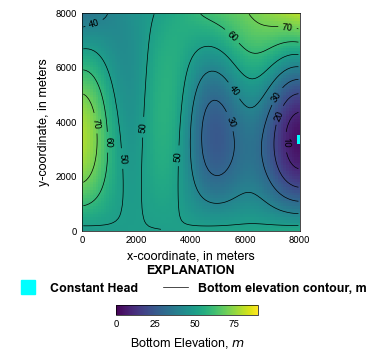

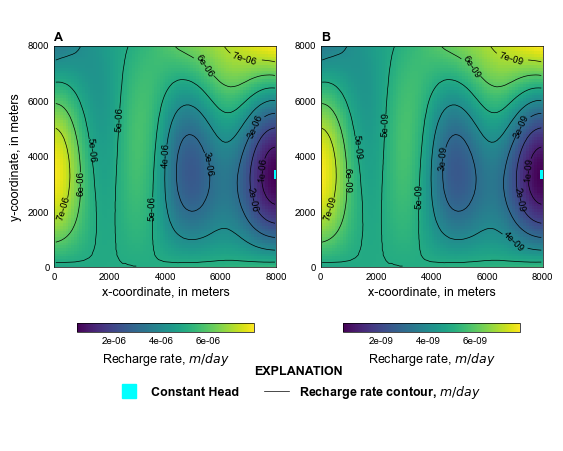

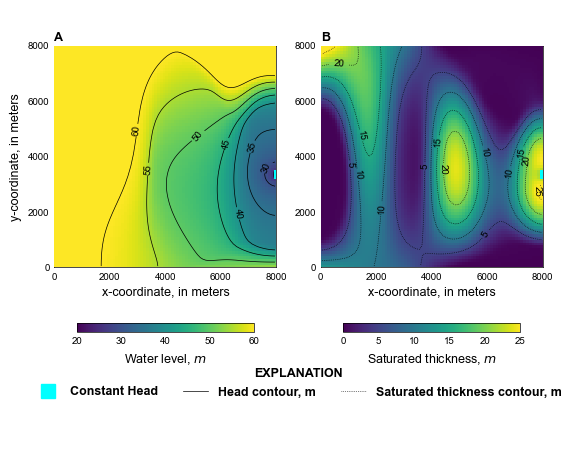

In [6]:
scenario(0)

Run the MODFLOW-NWT Problem 3 model with low recharge, then plot heads.

run_models took 2200.00 ms


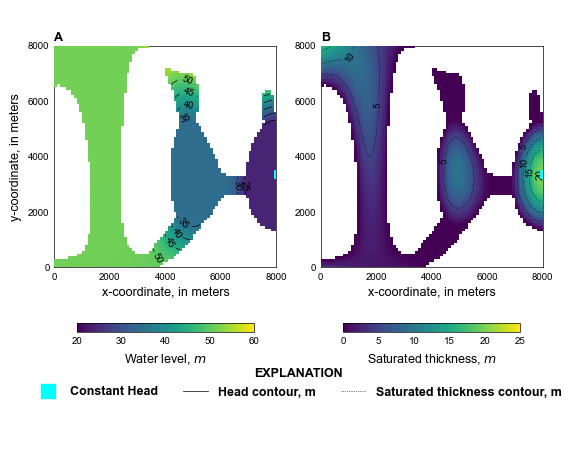

In [7]:
scenario(1)